# **Reinforcement Learning Individual Assignment**

*Maria Kontaratou*

In [23]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

import os
import sys
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import text_flappy_bird_gym
import seaborn as sns


  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-rlmvn76r
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-rlmvn76r
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py) ... done


# **1. Implementation of the agents**

## **Monte Carlo Agent**


The Monte Carlo (MC) agent is implemented using an **epsilon-greedy policy** to balance exploration and exploitation while learning optimal actions. The training process follows the **First-Visit MC method**, updating Q-values only after completing full episodes. 

### **State Representation**
- The state space in **Text Flappy Bird** is represented using discrete numerical values, including:
  - **Horizontal distance** to the next pipe
  - **Vertical velocity** of the bird
- This structured representation allows for tabular **Q-learning**, where a **Q-table** is used to store values for each **state-action pair** encountered during training.

### **Action Selection**
- The agent follows an **epsilon-greedy policy**, where it selects the best action based on current Q-values with probability $(1 - \epsilon)$.
- With probability $\epsilon$, it selects a random action to encourage exploration.
- **Epsilon decays** over time to shift from exploration to exploitation.

### **Rewards**
- The reward function is pre-defined by the environment.
- The agent receives feedback after each action through env.step(action), which is used to update its Q-values

### **Episode Generation**
- The agent interacts with the **Text Flappy Bird** environment by executing actions based on computed action probabilities.
- If a state is **not in the Q-table**, a random action is chosen to ensure exploration.
- The agent **stores** the sequence of states, actions, and rewards for the episode.

### **Q-Table Update (First-Visit MC)**
- Once an episode ends, **returns (G)** are computed for each state-action pair, considering future rewards:
  
  $$ G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... + \gamma^{T-t-1} R_T $$

- The **Q-values** are updated using the learning rate $(\alpha)$ and discount factor $(\gamma)$:
  
  $$ Q(s, a) \leftarrow Q(s, a) + \alpha (G - Q(s, a)) $$

- Only the **first occurrence** of each state-action pair in an episode contributes to the update.


In [24]:
def compute_action_probabilities(Q_s, epsilon, num_actions):
    """Generates epsilon-greedy action probabilities for a given state"""
    probabilities = np.ones(num_actions) * epsilon / num_actions
    best_action = np.argmax(Q_s)
    probabilities[best_action] = 1 - epsilon + (epsilon / num_actions)
    return probabilities


def generate_mc_episode(env, Q, epsilon, num_actions, max_steps=2000):
    """Generates an episode using epsilon-greedy strategy"""
    episode = []
    state = env.reset()[0]
    total_reward = 0

    while True:
        action = np.random.choice(np.arange(num_actions), p=compute_action_probabilities(Q[state], epsilon, num_actions)) \
                 if state in Q else env.action_space.sample()
        next_state, reward, done, _, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        total_reward += reward

        if done or total_reward >= max_steps:
            break
    return episode


def update_mc_q_table(Q, episode, alpha, gamma):
    """Updates the Monte Carlo Q-table using First-Visit MC"""
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards) + 1)])

    for i, state in enumerate(states):
        G = sum(rewards[i:] * discounts[:-(1 + i)])  # Compute return
        Q[state][actions[i]] += alpha * (G - Q[state][actions[i]])  # First-visit update
    return Q


### **Training Process**
- The training runs for **100,000 episodes**, adjusting epsilon and updating Q-values.
- Rewards per episode are **tracked** and plotted along with a **moving average** to observe performance trends.
- The final **optimal policy** is extracted by selecting the action with the highest Q-value for each state.


In [26]:
def train_mc_agent(env, num_episodes, alpha, gamma=1.0, epsilon_start=1.0, epsilon_decay=0.99999, epsilon_min=0.05, max_steps=2000):
    """Trains a Monte Carlo agent using an epsilon-greedy policy."""
    num_actions = env.action_space.n
    Q = defaultdict(lambda: np.zeros(num_actions))
    epsilon = epsilon_start
    episode_rewards = []

    for episode in tqdm(range(1, num_episodes + 1), desc="Training MC Control"):
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        episode_data = generate_mc_episode(env, Q, epsilon, num_actions, max_steps)
        episode_rewards.append(sum([step[2] for step in episode_data]))
        Q = update_mc_q_table(Q, episode_data, alpha, gamma)

        if episode % 1000 == 0:
            print(f"\rEpisode {episode}/{num_episodes} | Avg Reward: {np.mean(episode_rewards[-100:]):.2f}", end="")
            sys.stdout.flush()

    policy = {state: np.argmax(actions) for state, actions in Q.items()}
    return policy, Q, episode_rewards


Training MC Control:   1%|          | 957/100000 [00:00<01:27, 1136.32it/s]

Episode 1000/100000 | Avg Reward: 11.27

Training MC Control:   2%|▏         | 1947/100000 [00:01<01:21, 1199.48it/s]

Episode 2000/100000 | Avg Reward: 12.48

Training MC Control:   3%|▎         | 2986/100000 [00:02<01:33, 1033.10it/s]

Episode 3000/100000 | Avg Reward: 11.69

Training MC Control:   4%|▍         | 3899/100000 [00:03<01:32, 1037.03it/s]

Episode 4000/100000 | Avg Reward: 12.56

Training MC Control:   5%|▍         | 4897/100000 [00:04<01:26, 1099.83it/s]

Episode 5000/100000 | Avg Reward: 12.73

Training MC Control:   6%|▌         | 5995/100000 [00:05<01:30, 1040.08it/s]

Episode 6000/100000 | Avg Reward: 11.82

Training MC Control:   7%|▋         | 6941/100000 [00:06<01:36, 965.90it/s]

Episode 7000/100000 | Avg Reward: 11.94

Training MC Control:   8%|▊         | 7945/100000 [00:07<01:27, 1046.42it/s]

Episode 8000/100000 | Avg Reward: 11.81

Training MC Control:   9%|▉         | 8917/100000 [00:08<01:41, 898.83it/s]

Episode 9000/100000 | Avg Reward: 12.68

Training MC Control:  10%|▉         | 9923/100000 [00:10<01:53, 792.90it/s]

Episode 10000/100000 | Avg Reward: 12.80

Training MC Control:  11%|█         | 10953/100000 [00:11<01:46, 832.90it/s]

Episode 11000/100000 | Avg Reward: 13.99

Training MC Control:  12%|█▏        | 11922/100000 [00:12<01:33, 941.94it/s]

Episode 12000/100000 | Avg Reward: 13.75

Training MC Control:  13%|█▎        | 12940/100000 [00:13<01:37, 890.82it/s]

Episode 13000/100000 | Avg Reward: 14.04

Training MC Control:  14%|█▍        | 13930/100000 [00:14<01:28, 972.13it/s]

Episode 14000/100000 | Avg Reward: 12.89

Training MC Control:  15%|█▍        | 14928/100000 [00:15<01:32, 917.75it/s]

Episode 15000/100000 | Avg Reward: 14.63

Training MC Control:  16%|█▌        | 15984/100000 [00:17<01:40, 835.82it/s]

Episode 16000/100000 | Avg Reward: 14.64

Training MC Control:  17%|█▋        | 16993/100000 [00:18<01:39, 832.73it/s]

Episode 17000/100000 | Avg Reward: 13.61

Training MC Control:  18%|█▊        | 17985/100000 [00:19<01:32, 889.44it/s]

Episode 18000/100000 | Avg Reward: 13.23

Training MC Control:  19%|█▉        | 18936/100000 [00:20<01:30, 890.92it/s]

Episode 19000/100000 | Avg Reward: 12.66

Training MC Control:  20%|█▉        | 19996/100000 [00:21<01:54, 701.73it/s]

Episode 20000/100000 | Avg Reward: 13.65

Training MC Control:  21%|██        | 20994/100000 [00:23<02:01, 649.38it/s]

Episode 21000/100000 | Avg Reward: 15.27

Training MC Control:  22%|██▏       | 21915/100000 [00:24<01:23, 933.47it/s]

Episode 22000/100000 | Avg Reward: 15.03

Training MC Control:  23%|██▎       | 22972/100000 [00:25<01:24, 913.30it/s]

Episode 23000/100000 | Avg Reward: 13.67

Training MC Control:  24%|██▍       | 23995/100000 [00:26<01:31, 826.26it/s]

Episode 24000/100000 | Avg Reward: 14.45

Training MC Control:  25%|██▍       | 24983/100000 [00:27<01:26, 870.45it/s]

Episode 25000/100000 | Avg Reward: 14.89

Training MC Control:  26%|██▌       | 25936/100000 [00:29<01:31, 809.91it/s]

Episode 26000/100000 | Avg Reward: 14.03

Training MC Control:  27%|██▋       | 26980/100000 [00:30<01:38, 741.47it/s]

Episode 27000/100000 | Avg Reward: 16.34

Training MC Control:  28%|██▊       | 27990/100000 [00:31<01:34, 758.59it/s]

Episode 28000/100000 | Avg Reward: 16.40

Training MC Control:  29%|██▉       | 28979/100000 [00:33<01:24, 836.66it/s]

Episode 29000/100000 | Avg Reward: 15.67

Training MC Control:  30%|██▉       | 29991/100000 [00:34<01:48, 643.80it/s]

Episode 30000/100000 | Avg Reward: 14.98

Training MC Control:  31%|███       | 30958/100000 [00:36<01:56, 591.72it/s]

Episode 31000/100000 | Avg Reward: 15.74

Training MC Control:  32%|███▏      | 31978/100000 [00:37<01:20, 845.62it/s]

Episode 32000/100000 | Avg Reward: 16.66

Training MC Control:  33%|███▎      | 32983/100000 [00:38<01:23, 802.57it/s]

Episode 33000/100000 | Avg Reward: 15.23

Training MC Control:  34%|███▍      | 33976/100000 [00:40<01:30, 727.38it/s]

Episode 34000/100000 | Avg Reward: 16.31

Training MC Control:  35%|███▍      | 34962/100000 [00:41<01:24, 772.09it/s]

Episode 35000/100000 | Avg Reward: 16.84

Training MC Control:  36%|███▌      | 35943/100000 [00:42<01:28, 721.17it/s]

Episode 36000/100000 | Avg Reward: 18.51

Training MC Control:  37%|███▋      | 36942/100000 [00:43<01:20, 778.76it/s]

Episode 37000/100000 | Avg Reward: 18.20

Training MC Control:  38%|███▊      | 37966/100000 [00:45<01:17, 804.79it/s]

Episode 38000/100000 | Avg Reward: 17.47

Training MC Control:  39%|███▉      | 38943/100000 [00:46<01:43, 592.47it/s]

Episode 39000/100000 | Avg Reward: 18.32

Training MC Control:  40%|███▉      | 39965/100000 [00:48<01:56, 513.85it/s]

Episode 40000/100000 | Avg Reward: 17.55

Training MC Control:  41%|████      | 40952/100000 [00:49<01:20, 733.73it/s]

Episode 41000/100000 | Avg Reward: 18.02

Training MC Control:  42%|████▏     | 41970/100000 [00:51<01:23, 695.63it/s]

Episode 42000/100000 | Avg Reward: 18.54

Training MC Control:  43%|████▎     | 42954/100000 [00:52<01:16, 742.63it/s]

Episode 43000/100000 | Avg Reward: 18.39

Training MC Control:  44%|████▍     | 43998/100000 [00:54<01:20, 697.46it/s]

Episode 44000/100000 | Avg Reward: 18.37

Training MC Control:  45%|████▍     | 44990/100000 [00:55<01:15, 727.27it/s]

Episode 45000/100000 | Avg Reward: 17.52

Training MC Control:  46%|████▌     | 45998/100000 [00:57<01:13, 730.04it/s]

Episode 46000/100000 | Avg Reward: 18.84

Training MC Control:  47%|████▋     | 46947/100000 [00:58<01:14, 716.37it/s]

Episode 47000/100000 | Avg Reward: 18.88

Training MC Control:  48%|████▊     | 47972/100000 [01:00<01:45, 494.20it/s]

Episode 48000/100000 | Avg Reward: 20.25

Training MC Control:  49%|████▉     | 48966/100000 [01:02<01:24, 602.88it/s]

Episode 49000/100000 | Avg Reward: 22.01

Training MC Control:  50%|████▉     | 49987/100000 [01:04<01:26, 578.36it/s]

Episode 50000/100000 | Avg Reward: 20.16

Training MC Control:  51%|█████     | 50992/100000 [01:05<01:11, 689.56it/s]

Episode 51000/100000 | Avg Reward: 18.73

Training MC Control:  52%|█████▏    | 51946/100000 [01:07<01:19, 602.56it/s]

Episode 52000/100000 | Avg Reward: 22.24

Training MC Control:  53%|█████▎    | 52969/100000 [01:08<01:09, 673.61it/s]

Episode 53000/100000 | Avg Reward: 19.06

Training MC Control:  54%|█████▍    | 53975/100000 [01:10<01:16, 599.36it/s]

Episode 54000/100000 | Avg Reward: 19.96

Training MC Control:  55%|█████▍    | 54996/100000 [01:12<01:39, 451.80it/s]

Episode 55000/100000 | Avg Reward: 20.45

Training MC Control:  56%|█████▌    | 55950/100000 [01:14<01:11, 613.78it/s]

Episode 56000/100000 | Avg Reward: 20.09

Training MC Control:  57%|█████▋    | 56998/100000 [01:16<01:29, 482.91it/s]

Episode 57000/100000 | Avg Reward: 20.35

Training MC Control:  58%|█████▊    | 57963/100000 [01:18<01:27, 482.90it/s]

Episode 58000/100000 | Avg Reward: 19.95

Training MC Control:  59%|█████▉    | 58981/100000 [01:19<01:05, 629.69it/s]

Episode 59000/100000 | Avg Reward: 20.54

Training MC Control:  60%|█████▉    | 59996/100000 [01:21<01:07, 594.35it/s]

Episode 60000/100000 | Avg Reward: 19.65

Training MC Control:  61%|██████    | 60977/100000 [01:23<01:19, 491.01it/s]

Episode 61000/100000 | Avg Reward: 25.02

Training MC Control:  62%|██████▏   | 61983/100000 [01:25<01:19, 478.53it/s]

Episode 62000/100000 | Avg Reward: 19.98

Training MC Control:  63%|██████▎   | 62969/100000 [01:27<00:57, 647.10it/s]

Episode 63000/100000 | Avg Reward: 19.63

Training MC Control:  64%|██████▍   | 63930/100000 [01:29<01:01, 583.92it/s]

Episode 64000/100000 | Avg Reward: 19.01

Training MC Control:  65%|██████▍   | 64987/100000 [01:31<01:07, 519.23it/s]

Episode 65000/100000 | Avg Reward: 25.47

Training MC Control:  66%|██████▌   | 65975/100000 [01:32<01:02, 548.09it/s]

Episode 66000/100000 | Avg Reward: 23.42

Training MC Control:  67%|██████▋   | 66982/100000 [01:34<00:59, 551.82it/s]

Episode 67000/100000 | Avg Reward: 24.06

Training MC Control:  68%|██████▊   | 67961/100000 [01:36<01:02, 514.99it/s]

Episode 68000/100000 | Avg Reward: 21.18

Training MC Control:  69%|██████▉   | 68990/100000 [01:39<01:08, 453.83it/s]

Episode 69000/100000 | Avg Reward: 24.85

Training MC Control:  70%|██████▉   | 69940/100000 [01:40<00:49, 601.77it/s]

Episode 70000/100000 | Avg Reward: 24.96

Training MC Control:  71%|███████   | 70980/100000 [01:42<01:00, 479.37it/s]

Episode 71000/100000 | Avg Reward: 22.97

Training MC Control:  72%|███████▏  | 71988/100000 [01:44<00:54, 513.03it/s]

Episode 72000/100000 | Avg Reward: 22.16

Training MC Control:  73%|███████▎  | 72939/100000 [01:46<00:49, 545.58it/s]

Episode 73000/100000 | Avg Reward: 21.20

Training MC Control:  74%|███████▍  | 73996/100000 [01:48<00:48, 539.58it/s]

Episode 74000/100000 | Avg Reward: 24.48

Training MC Control:  75%|███████▍  | 74993/100000 [01:51<01:12, 345.46it/s]

Episode 75000/100000 | Avg Reward: 25.26

Training MC Control:  76%|███████▌  | 75989/100000 [01:53<00:45, 525.39it/s]

Episode 76000/100000 | Avg Reward: 23.07

Training MC Control:  77%|███████▋  | 76954/100000 [01:55<00:46, 495.88it/s]

Episode 77000/100000 | Avg Reward: 27.82

Training MC Control:  78%|███████▊  | 77970/100000 [01:57<00:42, 519.35it/s]

Episode 78000/100000 | Avg Reward: 22.64

Training MC Control:  79%|███████▉  | 78963/100000 [01:59<00:42, 497.46it/s]

Episode 79000/100000 | Avg Reward: 28.14

Training MC Control:  80%|███████▉  | 79986/100000 [02:01<00:35, 561.84it/s]

Episode 80000/100000 | Avg Reward: 25.52

Training MC Control:  81%|████████  | 80952/100000 [02:03<00:53, 356.03it/s]

Episode 81000/100000 | Avg Reward: 24.22

Training MC Control:  82%|████████▏ | 81988/100000 [02:05<00:33, 532.36it/s]

Episode 82000/100000 | Avg Reward: 23.21

Training MC Control:  83%|████████▎ | 82967/100000 [02:07<00:36, 470.93it/s]

Episode 83000/100000 | Avg Reward: 29.73

Training MC Control:  84%|████████▍ | 83993/100000 [02:10<00:33, 472.75it/s]

Episode 84000/100000 | Avg Reward: 28.73

Training MC Control:  85%|████████▍ | 84980/100000 [02:12<00:34, 439.03it/s]

Episode 85000/100000 | Avg Reward: 26.79

Training MC Control:  86%|████████▌ | 85973/100000 [02:14<00:42, 333.28it/s]

Episode 86000/100000 | Avg Reward: 31.76

Training MC Control:  87%|████████▋ | 86980/100000 [02:17<00:26, 489.70it/s]

Episode 87000/100000 | Avg Reward: 28.01

Training MC Control:  88%|████████▊ | 87973/100000 [02:19<00:25, 478.83it/s]

Episode 88000/100000 | Avg Reward: 26.62

Training MC Control:  89%|████████▉ | 88960/100000 [02:21<00:23, 464.36it/s]

Episode 89000/100000 | Avg Reward: 26.01

Training MC Control:  90%|████████▉ | 89977/100000 [02:23<00:21, 457.87it/s]

Episode 90000/100000 | Avg Reward: 26.05

Training MC Control:  91%|█████████ | 90946/100000 [02:25<00:18, 492.06it/s]

Episode 91000/100000 | Avg Reward: 28.29

Training MC Control:  92%|█████████▏| 91955/100000 [02:28<00:29, 269.33it/s]

Episode 92000/100000 | Avg Reward: 30.93

Training MC Control:  93%|█████████▎| 92997/100000 [02:31<00:16, 417.92it/s]

Episode 93000/100000 | Avg Reward: 28.54

Training MC Control:  94%|█████████▍| 93953/100000 [02:33<00:13, 445.10it/s]

Episode 94000/100000 | Avg Reward: 28.24

Training MC Control:  95%|█████████▍| 94970/100000 [02:35<00:10, 458.57it/s]

Episode 95000/100000 | Avg Reward: 29.02

Training MC Control:  96%|█████████▌| 95963/100000 [02:38<00:09, 414.22it/s]

Episode 96000/100000 | Avg Reward: 30.34

Training MC Control:  97%|█████████▋| 96972/100000 [02:41<00:11, 269.07it/s]

Episode 97000/100000 | Avg Reward: 33.29

Training MC Control:  98%|█████████▊| 97989/100000 [02:43<00:04, 416.72it/s]

Episode 98000/100000 | Avg Reward: 29.55

Training MC Control:  99%|█████████▉| 98957/100000 [02:45<00:02, 433.83it/s]

Episode 99000/100000 | Avg Reward: 29.52

Training MC Control: 100%|█████████▉| 99983/100000 [02:48<00:00, 414.10it/s]

Episode 100000/100000 | Avg Reward: 28.34

Training MC Control: 100%|██████████| 100000/100000 [02:48<00:00, 593.87it/s]


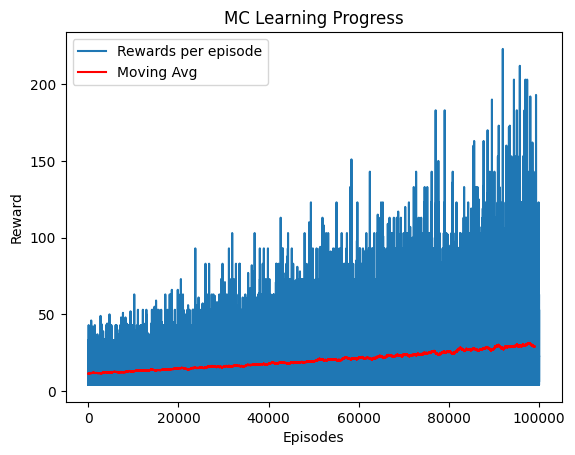

In [27]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

policy_mc, Q_mc, rewards_mc = train_mc_agent(env, num_episodes=100000, alpha=0.02)

plt.plot(rewards_mc, label="Rewards per episode")
plt.plot(np.convolve(rewards_mc, np.ones(1000) / 1000, mode='valid'), label="Moving Avg", color='r')
plt.title("MC Learning Progress")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.show()


## **SARSA(λ) Agent**


The SARSA(λ) agent is implemented using an epsilon-greedy policy combined with eligibility traces to enhance learning efficiency. This method enables the agent to update multiple state-action pairs simultaneously, making it more adaptive than standard SARSA.

### **State Representation**
- The state space in **Text Flappy Bird** is represented using discrete numerical values, including:
  - **Horizontal distance** to the next pipe
  - **Vertical velocity** of the bird
- This structured representation allows for tabular **Q-learning**, where a **Q-table** is used to store values for each **state-action pair** encountered during training.


### **Action Selection**
- The agent follows an epsilon-greedy policy to balance exploration (trying new actions) and exploitation (choosing the best-known action).
- The probability of selecting a random action ($\epsilon$) decreases over time using epsilon decay, ensuring more optimal decisions as training progresses.
- The best action is selected using Q-values, but random actions are introduced at a small probability to prevent premature convergence.

### **Rewards**
- The reward function is predefined by the **Text Flappy Bird** environment.
- The agent receives a **positive reward** for successfully passing through a pipe.
- A **negative reward (penalty)** is given when the bird collides with a pipe or the ground, terminating the episode.
- Unlike Monte Carlo, SARSA(λ) updates its **Q-values incrementally** after each action using the received reward, making it more adaptive to short-term feedback.

### **Episode Generation - Temporal Difference (TD) Learning Update**
- Each episode starts with the agent in an initial state and follows an epsilon-greedy policy to select actions.
- Unlike Monte Carlo, which updates Q-values at the end of an episode, SARSA(λ) updates Q-values at every time step, making it more responsive to immediate rewards
- The TD target is computed as:

  $$ TD_{\text{target}} = R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) $$

- The **TD error** is then calculated:

  $$ TD_{\text{error}} = TD_{\text{target}} - Q(S_t, A_t) $$

- Q-values are updated using eligibility traces:

  $$ Q(S, A) \leftarrow Q(S, A) + \alpha \cdot TD_{\text{error}} \cdot E(S, A) $$

- Decay factor (λ) controls how much past experiences contribute to current updates.


In [28]:
def initialize_sarsa_lambda(num_states, num_actions, epsilon_start, eps_decay, eps_min, step_size, discount, lambd, seed):
    """Initialize SARSA(λ) agent variables."""
    state_index = {}
    q_values = np.zeros((num_states, num_actions))
    eligibility_traces = np.zeros((num_states, num_actions))
    random_gen = np.random.RandomState(seed)

    return state_index, q_values, eligibility_traces, epsilon_start, eps_decay, eps_min, step_size, discount, lambd, random_gen

def epsilon_greedy_action(q_values, epsilon, num_actions, rand_generator):
    """
    Selects an action using an epsilon-greedy strategy.
    """
    if rand_generator.rand() < epsilon:
        return rand_generator.randint(num_actions)  # Explore (random action)
    else:
        return np.argmax(q_values)  # Exploit (best action)


### **Training Process**
- The agent is trained for **100,000 episodes**, gradually **reducing epsilon** to transition from exploration to exploitation.
- The **Q-table is updated continuously**, ensuring real-time policy improvements.
- The **policy** is derived by selecting the action with the highest Q-value at each state.


In [29]:
def train_sarsa_lambda(env, num_episodes, agent_params, max_steps=1000):
    """Trains a SARSA(λ) agent on the given environment."""
    state_index, q_values, eligibility_traces, epsilon, eps_decay, eps_min, step_size, discount, lambd, random_gen = initialize_sarsa_lambda(**agent_params)
    episode_rewards = []

    for episode in tqdm(range(num_episodes), desc="Training SARSA(λ)"):
        state, _ = env.reset()

        # Ensure state is in state_index
        if state not in state_index:
            state_index[state] = len(state_index)

        action = epsilon_greedy_action(q_values[state_index[state], :], epsilon, env.action_space.n, random_gen)
        episode_reward = 0

        while True:
            next_state, reward, done, _, _ = env.step(action)

            # Ensure next_state is also indexed
            if next_state not in state_index:
                state_index[next_state] = len(state_index)

            next_action = epsilon_greedy_action(q_values[state_index[next_state], :], epsilon, env.action_space.n, random_gen)

            td_target = reward + discount * q_values[state_index[next_state], next_action]
            td_error = td_target - q_values[state_index[state], action]

            eligibility_traces[state_index[state], action] += 1

            # Update Q-values
            q_values += step_size * td_error * eligibility_traces
            eligibility_traces *= discount * lambd

            if done:
                break

            state, action = next_state, next_action
            episode_reward += reward

        episode_rewards.append(episode_reward)
        epsilon = max(epsilon * eps_decay, eps_min)  # Decay epsilon over episodes

        if episode % 1000 == 0:
            print(f"\rEpisode {episode}/{num_episodes} | Avg Reward: {np.mean(episode_rewards[-100:]):.2f}", end="")
            sys.stdout.flush()

    policy = {state: np.argmax(q_values[state_index[state], :]) for state in state_index.keys()}
    return policy, q_values, episode_rewards



Training SARSA(λ):   0%|          | 0/100000 [00:00<?, ?it/s]

Episode 0/100000 | Avg Reward: 3.00

Training SARSA(λ):   1%|          | 707/100000 [00:00<00:14, 7068.76it/s]

Episode 1000/100000 | Avg Reward: 6.03

Training SARSA(λ):   1%|▏         | 1414/100000 [00:00<00:16, 6020.65it/s]

Episode 2000/100000 | Avg Reward: 8.98

Training SARSA(λ):   3%|▎         | 2552/100000 [00:00<00:21, 4632.05it/s]

Episode 3000/100000 | Avg Reward: 7.91

Training SARSA(λ):   4%|▍         | 3878/100000 [00:00<00:25, 3699.12it/s]

Episode 4000/100000 | Avg Reward: 11.13

Training SARSA(λ):   5%|▍         | 4866/100000 [00:01<00:35, 2705.29it/s]

Episode 5000/100000 | Avg Reward: 13.36

Training SARSA(λ):   6%|▌         | 5881/100000 [00:01<00:45, 2048.08it/s]

Episode 6000/100000 | Avg Reward: 21.48

Training SARSA(λ):   7%|▋         | 6925/100000 [00:02<01:03, 1476.76it/s]

Episode 7000/100000 | Avg Reward: 17.98

Training SARSA(λ):   8%|▊         | 7990/100000 [00:03<01:58, 773.70it/s]

Episode 8000/100000 | Avg Reward: 28.42

Training SARSA(λ):   9%|▉         | 8937/100000 [00:05<02:35, 586.60it/s]

Episode 9000/100000 | Avg Reward: 41.19

Training SARSA(λ):  10%|▉         | 9991/100000 [00:07<02:42, 552.91it/s]

Episode 10000/100000 | Avg Reward: 66.52

Training SARSA(λ):  11%|█         | 10961/100000 [00:09<03:16, 454.12it/s]

Episode 11000/100000 | Avg Reward: 55.27

Training SARSA(λ):  12%|█▏        | 12000/100000 [00:10<02:18, 635.26it/s]

Episode 12000/100000 | Avg Reward: 45.27

Training SARSA(λ):  13%|█▎        | 12995/100000 [00:12<02:54, 499.38it/s]

Episode 13000/100000 | Avg Reward: 51.81

Training SARSA(λ):  14%|█▍        | 13989/100000 [00:14<02:40, 534.38it/s]

Episode 14000/100000 | Avg Reward: 39.42

Training SARSA(λ):  15%|█▍        | 14985/100000 [00:17<05:43, 247.60it/s]

Episode 15000/100000 | Avg Reward: 79.08

Training SARSA(λ):  16%|█▌        | 15954/100000 [00:20<04:08, 337.54it/s]

Episode 16000/100000 | Avg Reward: 75.20

Training SARSA(λ):  17%|█▋        | 16966/100000 [00:22<03:07, 442.45it/s]

Episode 17000/100000 | Avg Reward: 64.49

Training SARSA(λ):  18%|█▊        | 17966/100000 [00:25<03:00, 454.80it/s]

Episode 18000/100000 | Avg Reward: 77.61

Training SARSA(λ):  19%|█▉        | 18995/100000 [00:27<03:08, 429.11it/s]

Episode 19000/100000 | Avg Reward: 68.88

Training SARSA(λ):  20%|█▉        | 19998/100000 [00:30<03:06, 429.19it/s]

Episode 20000/100000 | Avg Reward: 65.59

Training SARSA(λ):  21%|██        | 20968/100000 [00:33<03:05, 425.08it/s]

Episode 21000/100000 | Avg Reward: 76.74

Training SARSA(λ):  22%|██▏       | 21974/100000 [00:35<03:06, 417.81it/s]

Episode 22000/100000 | Avg Reward: 82.63

Training SARSA(λ):  23%|██▎       | 22964/100000 [00:37<03:12, 399.67it/s]

Episode 23000/100000 | Avg Reward: 79.14

Training SARSA(λ):  24%|██▍       | 23970/100000 [00:39<02:03, 615.74it/s]

Episode 24000/100000 | Avg Reward: 48.02

Training SARSA(λ):  25%|██▍       | 24955/100000 [00:42<03:24, 366.60it/s]

Episode 25000/100000 | Avg Reward: 41.73

Training SARSA(λ):  26%|██▌       | 25976/100000 [00:45<04:01, 306.04it/s]

Episode 26000/100000 | Avg Reward: 90.66

Training SARSA(λ):  27%|██▋       | 26988/100000 [00:47<02:46, 439.75it/s]

Episode 27000/100000 | Avg Reward: 46.99

Training SARSA(λ):  28%|██▊       | 27993/100000 [00:50<02:49, 424.94it/s]

Episode 28000/100000 | Avg Reward: 54.26

Training SARSA(λ):  29%|██▉       | 29000/100000 [00:52<02:38, 448.58it/s]

Episode 29000/100000 | Avg Reward: 53.45

Training SARSA(λ):  30%|██▉       | 29944/100000 [00:55<03:08, 371.46it/s]

Episode 30000/100000 | Avg Reward: 50.00

Training SARSA(λ):  31%|███       | 30973/100000 [00:58<02:17, 503.49it/s]

Episode 31000/100000 | Avg Reward: 95.90

Training SARSA(λ):  32%|███▏      | 31969/100000 [01:01<02:31, 449.84it/s]

Episode 32000/100000 | Avg Reward: 77.22

Training SARSA(λ):  33%|███▎      | 32991/100000 [01:03<03:04, 363.04it/s]

Episode 33000/100000 | Avg Reward: 75.44

Training SARSA(λ):  34%|███▍      | 33984/100000 [01:06<04:02, 272.39it/s]

Episode 34000/100000 | Avg Reward: 70.31

Training SARSA(λ):  35%|███▍      | 34975/100000 [01:09<02:52, 375.91it/s]

Episode 35000/100000 | Avg Reward: 83.90

Training SARSA(λ):  36%|███▌      | 35962/100000 [01:12<02:41, 396.09it/s]

Episode 36000/100000 | Avg Reward: 84.41

Training SARSA(λ):  37%|███▋      | 36979/100000 [01:15<02:31, 416.39it/s]

Episode 37000/100000 | Avg Reward: 65.47

Training SARSA(λ):  38%|███▊      | 37990/100000 [01:18<03:23, 305.31it/s]

Episode 38000/100000 | Avg Reward: 63.68

Training SARSA(λ):  39%|███▉      | 38948/100000 [01:21<02:39, 383.07it/s]

Episode 39000/100000 | Avg Reward: 55.55

Training SARSA(λ):  40%|███▉      | 39984/100000 [01:23<03:18, 301.68it/s]

Episode 40000/100000 | Avg Reward: 99.85

Training SARSA(λ):  41%|████      | 40963/100000 [01:27<02:38, 373.22it/s]

Episode 41000/100000 | Avg Reward: 52.09

Training SARSA(λ):  42%|████▏     | 41960/100000 [01:30<04:17, 224.99it/s]

Episode 42000/100000 | Avg Reward: 86.17

Training SARSA(λ):  43%|████▎     | 42985/100000 [01:34<02:28, 384.16it/s]

Episode 43000/100000 | Avg Reward: 59.30

Training SARSA(λ):  44%|████▍     | 43989/100000 [01:36<01:56, 479.60it/s]

Episode 44000/100000 | Avg Reward: 76.73

Training SARSA(λ):  45%|████▍     | 44980/100000 [01:40<03:11, 286.60it/s]

Episode 45000/100000 | Avg Reward: 94.56

Training SARSA(λ):  46%|████▌     | 45993/100000 [01:43<02:54, 309.17it/s]

Episode 46000/100000 | Avg Reward: 55.86

Training SARSA(λ):  47%|████▋     | 46980/100000 [01:46<01:56, 454.31it/s]

Episode 47000/100000 | Avg Reward: 55.64

Training SARSA(λ):  48%|████▊     | 47994/100000 [01:49<02:12, 392.00it/s]

Episode 48000/100000 | Avg Reward: 71.51

Training SARSA(λ):  49%|████▉     | 48970/100000 [01:51<02:32, 335.46it/s]

Episode 49000/100000 | Avg Reward: 73.10

Training SARSA(λ):  50%|████▉     | 49989/100000 [01:55<03:51, 216.44it/s]

Episode 50000/100000 | Avg Reward: 90.66

Training SARSA(λ):  51%|█████     | 50976/100000 [01:58<02:10, 374.89it/s]

Episode 51000/100000 | Avg Reward: 61.40

Training SARSA(λ):  52%|█████▏    | 51999/100000 [02:01<01:57, 409.91it/s]

Episode 52000/100000 | Avg Reward: 51.10

Training SARSA(λ):  53%|█████▎    | 52981/100000 [02:04<01:55, 407.84it/s]

Episode 53000/100000 | Avg Reward: 66.31

Training SARSA(λ):  54%|█████▍    | 53997/100000 [02:06<02:53, 264.50it/s]

Episode 54000/100000 | Avg Reward: 101.92

Training SARSA(λ):  55%|█████▍    | 54987/100000 [02:10<02:33, 294.14it/s]

Episode 55000/100000 | Avg Reward: 107.55

Training SARSA(λ):  56%|█████▌    | 55997/100000 [02:14<01:59, 368.17it/s]

Episode 56000/100000 | Avg Reward: 63.79

Training SARSA(λ):  57%|█████▋    | 56992/100000 [02:16<01:56, 369.17it/s]

Episode 57000/100000 | Avg Reward: 73.86

Training SARSA(λ):  58%|█████▊    | 57988/100000 [02:19<01:39, 421.11it/s]

Episode 58000/100000 | Avg Reward: 44.08

Training SARSA(λ):  59%|█████▉    | 58977/100000 [02:23<02:48, 243.07it/s]

Episode 59000/100000 | Avg Reward: 102.06

Training SARSA(λ):  60%|█████▉    | 59969/100000 [02:26<01:59, 333.69it/s]

Episode 60000/100000 | Avg Reward: 79.97

Training SARSA(λ):  61%|██████    | 60968/100000 [02:30<02:07, 306.94it/s]

Episode 61000/100000 | Avg Reward: 80.13

Training SARSA(λ):  62%|██████▏   | 61988/100000 [02:33<02:28, 256.38it/s]

Episode 62000/100000 | Avg Reward: 68.05

Training SARSA(λ):  63%|██████▎   | 62993/100000 [02:36<02:14, 275.56it/s]

Episode 63000/100000 | Avg Reward: 91.65

Training SARSA(λ):  64%|██████▍   | 63998/100000 [02:39<02:23, 251.05it/s]

Episode 64000/100000 | Avg Reward: 111.55

Training SARSA(λ):  65%|██████▍   | 64988/100000 [02:43<02:02, 286.36it/s]

Episode 65000/100000 | Avg Reward: 84.96

Training SARSA(λ):  66%|██████▌   | 65975/100000 [02:47<01:46, 319.04it/s]

Episode 66000/100000 | Avg Reward: 63.06

Training SARSA(λ):  67%|██████▋   | 66969/100000 [02:50<01:44, 314.71it/s]

Episode 67000/100000 | Avg Reward: 76.92

Training SARSA(λ):  68%|██████▊   | 67980/100000 [02:53<02:09, 247.67it/s]

Episode 68000/100000 | Avg Reward: 131.10

Training SARSA(λ):  69%|██████▉   | 68978/100000 [02:57<02:00, 257.84it/s]

Episode 69000/100000 | Avg Reward: 68.13

Training SARSA(λ):  70%|██████▉   | 69991/100000 [03:01<01:47, 279.38it/s]

Episode 70000/100000 | Avg Reward: 95.51

Training SARSA(λ):  71%|███████   | 70963/100000 [03:03<00:53, 540.77it/s]

Episode 71000/100000 | Avg Reward: 46.69

Training SARSA(λ):  72%|███████▏  | 71969/100000 [03:06<01:29, 312.59it/s]

Episode 72000/100000 | Avg Reward: 87.08

Training SARSA(λ):  73%|███████▎  | 72990/100000 [03:11<03:01, 148.99it/s]

Episode 73000/100000 | Avg Reward: 118.69

Training SARSA(λ):  74%|███████▍  | 73960/100000 [03:14<01:03, 408.60it/s]

Episode 74000/100000 | Avg Reward: 82.06

Training SARSA(λ):  75%|███████▍  | 74991/100000 [03:17<01:25, 291.57it/s]

Episode 75000/100000 | Avg Reward: 85.61

Training SARSA(λ):  76%|███████▌  | 75998/100000 [03:21<01:22, 291.24it/s]

Episode 76000/100000 | Avg Reward: 100.45

Training SARSA(λ):  77%|███████▋  | 76975/100000 [03:24<00:49, 469.66it/s]

Episode 77000/100000 | Avg Reward: 47.10

Training SARSA(λ):  78%|███████▊  | 77989/100000 [03:27<00:59, 371.90it/s]

Episode 78000/100000 | Avg Reward: 54.68

Training SARSA(λ):  79%|███████▉  | 78966/100000 [03:31<01:09, 301.17it/s]

Episode 79000/100000 | Avg Reward: 78.29

Training SARSA(λ):  80%|███████▉  | 79994/100000 [03:34<01:14, 269.49it/s]

Episode 80000/100000 | Avg Reward: 80.19

Training SARSA(λ):  81%|████████  | 80975/100000 [03:38<01:02, 304.44it/s]

Episode 81000/100000 | Avg Reward: 99.19

Training SARSA(λ):  82%|████████▏ | 81990/100000 [03:41<01:06, 271.84it/s]

Episode 82000/100000 | Avg Reward: 91.44

Training SARSA(λ):  83%|████████▎ | 82979/100000 [03:45<01:11, 238.85it/s]

Episode 83000/100000 | Avg Reward: 114.26

Training SARSA(λ):  84%|████████▍ | 83990/100000 [03:50<00:58, 272.66it/s]

Episode 84000/100000 | Avg Reward: 97.86

Training SARSA(λ):  85%|████████▍ | 84961/100000 [03:52<00:38, 388.70it/s]

Episode 85000/100000 | Avg Reward: 76.47

Training SARSA(λ):  86%|████████▌ | 85950/100000 [03:55<00:24, 566.00it/s]

Episode 86000/100000 | Avg Reward: 59.32

Training SARSA(λ):  87%|████████▋ | 86988/100000 [03:58<00:40, 317.69it/s]

Episode 87000/100000 | Avg Reward: 50.50

Training SARSA(λ):  88%|████████▊ | 87977/100000 [04:02<00:26, 462.22it/s]

Episode 88000/100000 | Avg Reward: 54.48

Training SARSA(λ):  89%|████████▉ | 88974/100000 [04:05<00:40, 274.35it/s]

Episode 89000/100000 | Avg Reward: 127.61

Training SARSA(λ):  90%|████████▉ | 89964/100000 [04:09<00:27, 368.20it/s]

Episode 90000/100000 | Avg Reward: 44.32

Training SARSA(λ):  91%|█████████ | 90978/100000 [04:12<00:45, 198.84it/s]

Episode 91000/100000 | Avg Reward: 102.41

Training SARSA(λ):  92%|█████████▏| 91997/100000 [04:16<00:30, 262.60it/s]

Episode 92000/100000 | Avg Reward: 103.43

Training SARSA(λ):  93%|█████████▎| 92974/100000 [04:19<00:29, 240.39it/s]

Episode 93000/100000 | Avg Reward: 141.40

Training SARSA(λ):  94%|█████████▍| 93992/100000 [04:25<00:46, 129.73it/s]

Episode 94000/100000 | Avg Reward: 112.25

Training SARSA(λ):  95%|█████████▍| 94982/100000 [04:30<00:21, 228.74it/s]

Episode 95000/100000 | Avg Reward: 134.37

Training SARSA(λ):  96%|█████████▌| 95987/100000 [04:33<00:14, 268.53it/s]

Episode 96000/100000 | Avg Reward: 106.88

Training SARSA(λ):  97%|█████████▋| 97000/100000 [04:37<00:19, 151.63it/s]

Episode 97000/100000 | Avg Reward: 97.08

Training SARSA(λ):  98%|█████████▊| 97976/100000 [04:42<00:08, 235.82it/s]

Episode 98000/100000 | Avg Reward: 126.41

Training SARSA(λ):  99%|█████████▉| 98979/100000 [04:45<00:03, 292.49it/s]

Episode 99000/100000 | Avg Reward: 94.03

Training SARSA(λ): 100%|██████████| 100000/100000 [04:49<00:00, 345.09it/s]


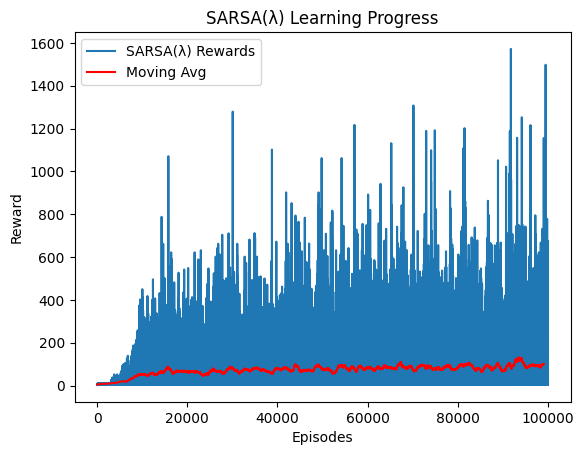

In [30]:
agent_params = {
    "num_states": 14 * 22,  # Based on (x, y) dimensions
    "num_actions": env.action_space.n,
    "epsilon_start": 0.1,
    "eps_decay": 0.99999,
    "eps_min": 0.01,
    "step_size": 0.1,
    "discount": 0.99,
    "lambd": 0.9,
    "seed": 42
}

policy_sarsa, q_sarsa, rewards_sarsa = train_sarsa_lambda(env, num_episodes=100000, agent_params=agent_params)

# Plot Learning Curve
plt.plot(rewards_sarsa, label="SARSA(λ) Rewards")
plt.plot(np.convolve(rewards_sarsa, np.ones(1000) / 1000, mode='valid'), label="Moving Avg", color='r')
plt.title("SARSA(λ) Learning Progress")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.show()

# **2. Plots**

### **Helper Functions**

In [ ]:
def visualize_value_function(value_function, title="State-Value Function"):
    """
    Plots a 3D representation of the state-value function.
    - Takes a dictionary of state values `V(s)`.
    - Uses `x` and `y` positions as the state representation.
    """
    x_vals, y_vals, z_vals = [], [], []

    for (x, y), value in value_function.items():
        x_vals.append(x)
        y_vals.append(y)
        z_vals.append(value)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(x_vals, y_vals, z_vals, cmap="viridis", edgecolor="none")
    ax.set_title(title)
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Velocity")
    ax.set_zlabel("State Value (V)")
    plt.show()


def visualize_learned_policy(policy, title="Learned Policy"):
    """
    Visualizes the learned policy as a heatmap.
    - Uses X (horizontal position) and Y (velocity) to represent states.
    - Maps each state to an action (0 = idle, 1 = flap).
    """
    policy_matrix = np.zeros((14, 22), dtype=int)  # 14 x-positions, 22 velocity values

    for state, action in policy.items():
        x, y = state
        y += 11  # Shift y-values to align with array indexing
        if 0 <= x < 14 and 0 <= y < 22:
            policy_matrix[x, y] = action  # Assign action (0 = idle, 1 = flap)

    plt.figure(figsize=(10, 5))
    plt.imshow(policy_matrix, cmap='coolwarm', extent=(0, 13, -11, 10))
    plt.title(title)
    plt.xlabel("X Position")
    plt.ylabel("Y Velocity")
    cbar = plt.colorbar()
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["Idle", "Flap"])
    plt.show()


def plot_hp_tuning(results, xlabel, title):
    """
    Plots the moving average of rewards for different hyperparameter settings.

    Args:
        results (dict): Dictionary where keys are (hyperparameter combinations) and values are reward lists.
        xlabel (str): Label for the x-axis.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(14, 6))

    for (hp1, hp2), rewards in results.items():
        if len(rewards) > 100:  # Avoid errors with too short reward lists
            smoothed_rewards = np.convolve(rewards, np.ones(100)/100, mode='valid')  # Moving average
            plt.plot(smoothed_rewards, label=f"step size, eps start=({hp1}, {hp2})")

    plt.xlabel("Number of Episodes")
    plt.ylabel("Moving Average Reward")
    plt.title(title)
    plt.legend()
    plt.show()  # Removed grid


### **Learned Policy**

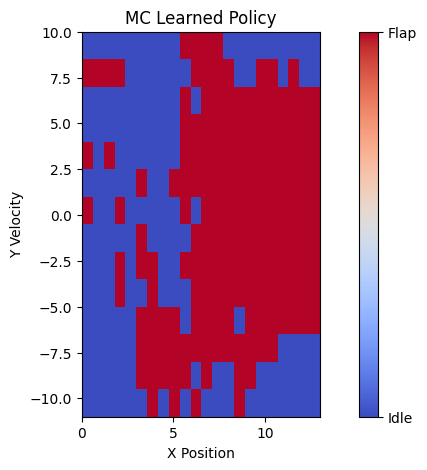

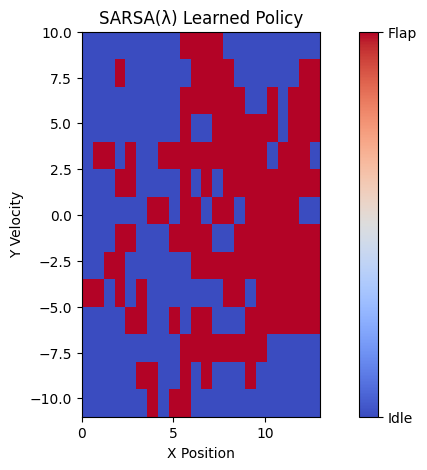

In [ ]:
visualize_learned_policy(policy_mc, "MC Learned Policy")
visualize_learned_policy(policy_sarsa, "SARSA(λ) Learned Policy")


### **State - Value function**

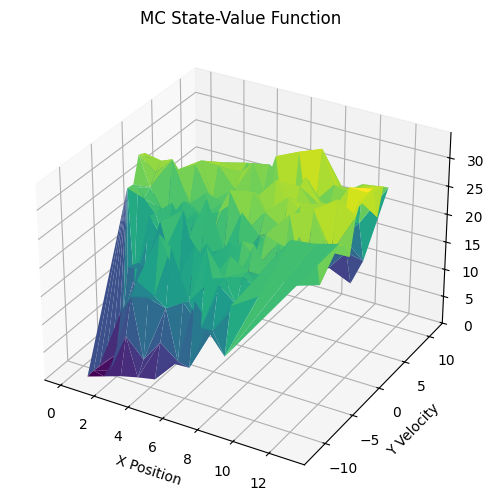

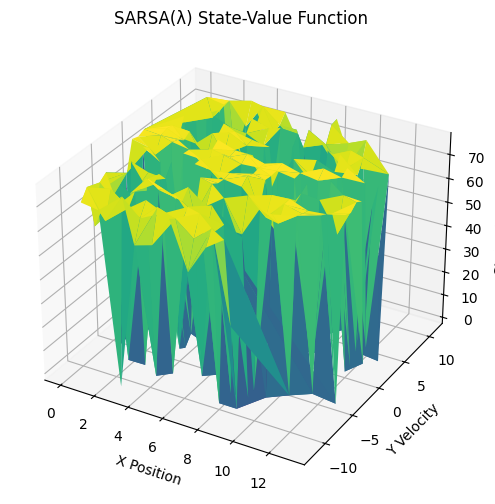

In [ ]:
# Convert SARSA(λ) q_sarsa array into a dictionary
Q_sarsa = {state: q_sarsa[idx] for idx, state in enumerate(Q_mc.keys())}

# Extract Value Function from Monte Carlo Q-table
V_mc = {state: np.max(q_values) for state, q_values in Q_mc.items()}

# Extract Value Function from SARSA(λ) Q-table
V_sarsa = {state: np.max(Q_sarsa[state]) for state in Q_sarsa.keys()}


# Plot Monte Carlo and SARSA(λ) Value Functions
visualize_value_function(V_mc, "MC State-Value Function")
visualize_value_function(V_sarsa, "SARSA(λ) State-Value Function")


### **Hypermarameter Tuning**


- For **MC**, we tuned:
  - **Step size (α):** {0.2, 0.4, 0.8, 1}
  - **Exploration rate (ε\_start):** {0.1, 0.5, 0.99}
- For **SARSA(λ)**, we tuned:
  - **Exploration rate (ε\_start):** {0.05, 0.1, 0.99}
  - **Step size (α):** {0.1, 0.4, 0.8, 1}

### **Implementation Approach**
- **Grid Search Strategy:** Each combination of hyperparameters was tested individually.
- **Training Environment:** We used TextFlappyBird-v0 with a fixed configuration (height=15, width=20, pipe\_gap=4).
- **Performance Metric:** Cumulative reward over **5000 episodes**.

### **Monte Carlo Tuning**
1. The total number of trials was computed as the Cartesian product of α and ε\_start values.
2. For each α-ε\_start pair:
   - The MC agent was trained using the `train_mc_agent()` function.
   - The resulting reward per episode was stored for later analysis.
   - The environment was reset before each run.

### **SARSA(λ) Tuning**
1. The total trials were computed as the Cartesian product of ε\_start and step size.
2. For each parameter set:
   - The SARSA(λ) agentwas trained using the `train_sarsa_lambda()` function.
   - The ewards were recorded for comparison.
   - The environment was properly reset between trials.

### **Results and Insights**
- **MC Findings:**
  - **Lower ε\_start values (0.1, 0.5)** led to more stable learning.
  - **Larger α (step sizes ≥ 0.8)** caused instability, whereas moderate values (0.2-0.4) performed best.
- **SARSA(λ) Findings:**
  - **Smaller ε values (0.05, 0.1)** resulted in more consistent learning.
  - **Step size (α)** had a **greater impact** on learning dynamics compared to MC.
  - **High α (0.8, 1)** led to erratic learning curves.




Training MC Control:  20%|█▉        | 999/5000 [00:03<00:25, 155.30it/s]

Episode 1000/5000 | Avg Reward: 77.86

Training MC Control:  40%|███▉      | 1992/5000 [00:18<01:21, 37.07it/s]

Episode 2000/5000 | Avg Reward: 170.34

Training MC Control:  60%|█████▉    | 2987/5000 [00:52<01:35, 21.16it/s]

Episode 3000/5000 | Avg Reward: 327.30

Training MC Control:  80%|███████▉  | 3998/5000 [02:29<01:11, 13.94it/s]

Episode 4000/5000 | Avg Reward: 767.51

Training MC Control: 100%|█████████▉| 4996/5000 [04:47<00:00, 18.64it/s]

Episode 5000/5000 | Avg Reward: 772.02

Training MC Control: 100%|██████████| 5000/5000 [04:47<00:00, 17.39it/s]


MC Trial 1/12


Training MC Control:  19%|█▉        | 963/5000 [00:01<00:09, 419.48it/s]

Episode 1000/5000 | Avg Reward: 39.49

Training MC Control:  40%|███▉      | 1987/5000 [00:06<00:20, 146.70it/s]

Episode 2000/5000 | Avg Reward: 89.11

Training MC Control:  60%|█████▉    | 2998/5000 [00:16<00:21, 95.25it/s] 

Episode 3000/5000 | Avg Reward: 117.43

Training MC Control:  80%|███████▉  | 3985/5000 [00:37<00:22, 44.76it/s]

Episode 4000/5000 | Avg Reward: 244.84

Training MC Control: 100%|█████████▉| 4999/5000 [01:31<00:00, 18.88it/s]

Episode 5000/5000 | Avg Reward: 315.77

Training MC Control: 100%|██████████| 5000/5000 [01:31<00:00, 54.59it/s]


MC Trial 2/12


Training MC Control:  19%|█▉        | 962/5000 [00:01<00:06, 609.06it/s]

Episode 1000/5000 | Avg Reward: 22.12

Training MC Control:  39%|███▉      | 1971/5000 [00:04<00:10, 281.13it/s]

Episode 2000/5000 | Avg Reward: 49.57

Training MC Control:  60%|█████▉    | 2981/5000 [00:09<00:14, 137.42it/s]

Episode 3000/5000 | Avg Reward: 74.89

Training MC Control:  80%|███████▉  | 3996/5000 [00:22<00:14, 70.65it/s]

Episode 4000/5000 | Avg Reward: 150.18

Training MC Control: 100%|█████████▉| 4997/5000 [00:54<00:00, 17.39it/s]

Episode 5000/5000 | Avg Reward: 315.31

Training MC Control: 100%|██████████| 5000/5000 [00:54<00:00, 92.19it/s]


MC Trial 3/12


Training MC Control:  20%|█▉        | 978/5000 [00:02<00:22, 180.88it/s]

Episode 1000/5000 | Avg Reward: 79.01

Training MC Control:  40%|███▉      | 1992/5000 [00:14<00:42, 71.01it/s]

Episode 2000/5000 | Avg Reward: 149.18

Training MC Control:  60%|█████▉    | 2997/5000 [00:47<01:08, 29.35it/s]

Episode 3000/5000 | Avg Reward: 267.45

Training MC Control:  80%|███████▉  | 3998/5000 [02:06<02:12,  7.57it/s]

Episode 4000/5000 | Avg Reward: 669.21

Training MC Control: 100%|█████████▉| 4999/5000 [04:49<00:00,  8.37it/s]

Episode 5000/5000 | Avg Reward: 747.04

Training MC Control: 100%|██████████| 5000/5000 [04:49<00:00, 17.25it/s]


MC Trial 4/12


Training MC Control:  20%|█▉        | 996/5000 [00:01<00:08, 494.11it/s]

Episode 1000/5000 | Avg Reward: 30.88

Training MC Control:  40%|███▉      | 1999/5000 [00:05<00:16, 176.90it/s]

Episode 2000/5000 | Avg Reward: 81.19

Training MC Control:  60%|█████▉    | 2999/5000 [00:13<00:26, 75.83it/s]

Episode 3000/5000 | Avg Reward: 153.58

Training MC Control:  80%|███████▉  | 3993/5000 [00:34<00:40, 25.01it/s]

Episode 4000/5000 | Avg Reward: 275.02

Training MC Control: 100%|█████████▉| 4996/5000 [01:37<00:00, 23.45it/s]

Episode 5000/5000 | Avg Reward: 594.08

Training MC Control: 100%|██████████| 5000/5000 [01:37<00:00, 51.06it/s]


MC Trial 5/12


Training MC Control:  20%|█▉        | 993/5000 [00:01<00:05, 709.90it/s]

Episode 1000/5000 | Avg Reward: 23.97

Training MC Control:  40%|███▉      | 1997/5000 [00:03<00:07, 392.78it/s]

Episode 2000/5000 | Avg Reward: 41.44

Training MC Control:  60%|█████▉    | 2998/5000 [00:08<00:12, 154.59it/s]

Episode 3000/5000 | Avg Reward: 90.03

Training MC Control:  80%|███████▉  | 3996/5000 [00:20<00:19, 51.90it/s]

Episode 4000/5000 | Avg Reward: 188.32

Training MC Control: 100%|█████████▉| 4995/5000 [00:52<00:00, 42.82it/s]

Episode 5000/5000 | Avg Reward: 351.53

Training MC Control: 100%|██████████| 5000/5000 [00:53<00:00, 93.72it/s]


MC Trial 6/12


Training MC Control:  20%|█▉        | 985/5000 [00:04<00:30, 129.92it/s]

Episode 1000/5000 | Avg Reward: 98.94

Training MC Control:  40%|███▉      | 1998/5000 [00:17<00:41, 71.48it/s]

Episode 2000/5000 | Avg Reward: 158.51

Training MC Control:  60%|█████▉    | 2998/5000 [01:04<02:24, 13.85it/s]

Episode 3000/5000 | Avg Reward: 520.36

Training MC Control:  80%|███████▉  | 3999/5000 [02:35<01:53,  8.80it/s]

Episode 4000/5000 | Avg Reward: 764.89

Training MC Control: 100%|█████████▉| 4999/5000 [04:15<00:00, 10.12it/s]

Episode 5000/5000 | Avg Reward: 503.54

Training MC Control: 100%|██████████| 5000/5000 [04:15<00:00, 19.55it/s]


MC Trial 7/12


Training MC Control:  20%|█▉        | 987/5000 [00:01<00:07, 559.87it/s]

Episode 1000/5000 | Avg Reward: 28.50

Training MC Control:  40%|███▉      | 1985/5000 [00:04<00:13, 228.63it/s]

Episode 2000/5000 | Avg Reward: 68.42

Training MC Control:  60%|█████▉    | 2996/5000 [00:14<00:30, 65.00it/s]

Episode 3000/5000 | Avg Reward: 134.28

Training MC Control:  80%|███████▉  | 3998/5000 [00:37<00:25, 38.96it/s]

Episode 4000/5000 | Avg Reward: 204.88

Training MC Control: 100%|█████████▉| 4995/5000 [01:39<00:00, 14.40it/s]

Episode 5000/5000 | Avg Reward: 395.55

Training MC Control: 100%|██████████| 5000/5000 [01:39<00:00, 50.07it/s]


MC Trial 8/12


Training MC Control:  20%|█▉        | 997/5000 [00:01<00:05, 744.66it/s]

Episode 1000/5000 | Avg Reward: 21.39

Training MC Control:  40%|███▉      | 1977/5000 [00:03<00:07, 400.31it/s]

Episode 2000/5000 | Avg Reward: 43.00

Training MC Control:  60%|█████▉    | 2992/5000 [00:07<00:15, 133.36it/s]

Episode 3000/5000 | Avg Reward: 77.57

Training MC Control:  80%|███████▉  | 3992/5000 [00:21<00:11, 88.47it/s]

Episode 4000/5000 | Avg Reward: 155.07

Training MC Control: 100%|█████████▉| 4999/5000 [00:58<00:00, 15.44it/s]

Episode 5000/5000 | Avg Reward: 316.11

Training MC Control: 100%|██████████| 5000/5000 [00:58<00:00, 85.33it/s]


MC Trial 9/12


Training MC Control:  20%|█▉        | 987/5000 [00:01<00:08, 484.29it/s]

Episode 1000/5000 | Avg Reward: 37.47

Training MC Control:  40%|███▉      | 1976/5000 [00:05<00:14, 215.60it/s]

Episode 2000/5000 | Avg Reward: 43.62

Training MC Control:  60%|█████▉    | 2992/5000 [00:12<00:04, 430.08it/s]

Episode 3000/5000 | Avg Reward: 23.87

Training MC Control:  79%|███████▉  | 3960/5000 [00:13<00:01, 624.43it/s]

Episode 4000/5000 | Avg Reward: 23.80

Training MC Control: 100%|█████████▉| 4976/5000 [00:15<00:00, 635.58it/s]

Episode 5000/5000 | Avg Reward: 26.30

Training MC Control: 100%|██████████| 5000/5000 [00:15<00:00, 316.47it/s]


MC Trial 10/12


Training MC Control:  19%|█▉        | 946/5000 [00:01<00:05, 698.33it/s]

Episode 1000/5000 | Avg Reward: 25.54

Training MC Control:  40%|███▉      | 1980/5000 [00:04<00:08, 341.27it/s]

Episode 2000/5000 | Avg Reward: 34.43

Training MC Control:  60%|█████▉    | 2981/5000 [00:08<00:05, 392.35it/s]

Episode 3000/5000 | Avg Reward: 29.57

Training MC Control:  80%|███████▉  | 3992/5000 [00:13<00:03, 320.35it/s]

Episode 4000/5000 | Avg Reward: 32.61

Training MC Control:  99%|█████████▉| 4973/5000 [00:16<00:00, 410.73it/s]

Episode 5000/5000 | Avg Reward: 35.71

Training MC Control: 100%|██████████| 5000/5000 [00:16<00:00, 305.75it/s]


MC Trial 11/12


Training MC Control:  19%|█▊        | 930/5000 [00:01<00:04, 816.97it/s]

Episode 1000/5000 | Avg Reward: 18.01

Training MC Control:  40%|███▉      | 1998/5000 [00:02<00:05, 520.86it/s]

Episode 2000/5000 | Avg Reward: 34.62

Training MC Control:  60%|█████▉    | 2980/5000 [00:06<00:08, 244.17it/s]

Episode 3000/5000 | Avg Reward: 69.16

Training MC Control:  80%|███████▉  | 3994/5000 [00:08<00:03, 288.88it/s]

Episode 4000/5000 | Avg Reward: 50.26

Training MC Control:  99%|█████████▉| 4968/5000 [00:13<00:00, 282.74it/s]

Episode 5000/5000 | Avg Reward: 37.46

Training MC Control: 100%|██████████| 5000/5000 [00:13<00:00, 375.39it/s]


MC Trial 12/12


Training SARSA(λ):   0%|          | 0/5000 [00:00<?, ?it/s]

Episode 0/5000 | Avg Reward: 3.00

Training SARSA(λ):  17%|█▋        | 840/5000 [00:00<00:00, 8390.99it/s]

Episode 1000/5000 | Avg Reward: 3.04

Training SARSA(λ):  34%|███▎      | 1680/5000 [00:00<00:00, 7675.43it/s]

Episode 2000/5000 | Avg Reward: 3.04

Training SARSA(λ):  49%|████▉     | 2452/5000 [00:00<00:00, 7470.60it/s]

Episode 3000/5000 | Avg Reward: 3.00

Training SARSA(λ):  64%|██████▍   | 3219/5000 [00:00<00:00, 7542.51it/s]

Episode 4000/5000 | Avg Reward: 3.02

Training SARSA(λ): 100%|██████████| 5000/5000 [00:00<00:00, 7685.65it/s]


SARSA Trial 1/12


Training SARSA(λ):   0%|          | 0/5000 [00:00<?, ?it/s]

Episode 0/5000 | Avg Reward: 3.00

Training SARSA(λ):  15%|█▍        | 733/5000 [00:00<00:00, 7320.58it/s]

Episode 1000/5000 | Avg Reward: 3.67

Training SARSA(λ):  29%|██▉       | 1466/5000 [00:00<00:00, 6543.20it/s]

Episode 2000/5000 | Avg Reward: 5.41

Training SARSA(λ):  43%|████▎     | 2126/5000 [00:00<00:00, 6394.19it/s]

Episode 3000/5000 | Avg Reward: 5.53

Training SARSA(λ):  75%|███████▌  | 3764/5000 [00:00<00:00, 7388.99it/s]

Episode 4000/5000 | Avg Reward: 7.94

Training SARSA(λ): 100%|██████████| 5000/5000 [00:00<00:00, 6858.92it/s]


SARSA Trial 2/12


Training SARSA(λ):   0%|          | 0/5000 [00:00<?, ?it/s]

Episode 0/5000 | Avg Reward: 3.00

Training SARSA(λ):  18%|█▊        | 902/5000 [00:00<00:00, 9018.61it/s]

Episode 1000/5000 | Avg Reward: 5.80

Training SARSA(λ):  36%|███▌      | 1804/5000 [00:00<00:00, 7717.38it/s]

Episode 2000/5000 | Avg Reward: 8.69

Training SARSA(λ):  52%|█████▏    | 2588/5000 [00:00<00:00, 6295.88it/s]

Episode 3000/5000 | Avg Reward: 19.90

Training SARSA(λ):  75%|███████▍  | 3745/5000 [00:00<00:00, 2993.41it/s]

Episode 4000/5000 | Avg Reward: 94.38

Training SARSA(λ): 100%|██████████| 5000/5000 [00:03<00:00, 1266.13it/s]


SARSA Trial 3/12


Training SARSA(λ):   0%|          | 0/5000 [00:00<?, ?it/s]

Episode 0/5000 | Avg Reward: 3.00

Training SARSA(λ):  16%|█▌        | 794/5000 [00:00<00:00, 7930.95it/s]

Episode 1000/5000 | Avg Reward: 8.95

Training SARSA(λ):  32%|███▏      | 1588/5000 [00:00<00:00, 6482.15it/s]

Episode 2000/5000 | Avg Reward: 9.86

Training SARSA(λ):  57%|█████▋    | 2845/5000 [00:00<00:00, 3806.09it/s]

Episode 3000/5000 | Avg Reward: 41.89

Training SARSA(λ):  77%|███████▋  | 3851/5000 [00:02<00:01, 734.29it/s] 

Episode 4000/5000 | Avg Reward: 168.32

Training SARSA(λ): 100%|██████████| 5000/5000 [00:04<00:00, 1007.01it/s]


SARSA Trial 4/12


Training SARSA(λ):   0%|          | 0/5000 [00:00<?, ?it/s]

Episode 1000/5000 | Avg Reward: 3.05

Training SARSA(λ):  23%|██▎       | 1173/5000 [00:00<00:00, 11724.67it/s]

Episode 2000/5000 | Avg Reward: 3.05

Training SARSA(λ):  47%|████▋     | 2346/5000 [00:00<00:00, 11188.10it/s]

Episode 3000/5000 | Avg Reward: 3.03

Training SARSA(λ):  69%|██████▉   | 3474/5000 [00:00<00:00, 11227.72it/s]

Episode 4000/5000 | Avg Reward: 3.60

Training SARSA(λ): 100%|██████████| 5000/5000 [00:00<00:00, 11322.87it/s]


SARSA Trial 5/12


Training SARSA(λ):   0%|          | 0/5000 [00:00<?, ?it/s]

Episode 0/5000 | Avg Reward: 3.00

Training SARSA(λ):  18%|█▊        | 921/5000 [00:00<00:00, 9204.79it/s]

Episode 1000/5000 | Avg Reward: 5.31

Training SARSA(λ):  37%|███▋      | 1842/5000 [00:00<00:00, 5790.10it/s]

Episode 2000/5000 | Avg Reward: 7.37

Training SARSA(λ):  50%|████▉     | 2492/5000 [00:00<00:00, 4855.57it/s]

Episode 3000/5000 | Avg Reward: 8.21

Training SARSA(λ):  78%|███████▊  | 3895/5000 [00:00<00:00, 3823.56it/s]

Episode 4000/5000 | Avg Reward: 9.47

Training SARSA(λ): 100%|██████████| 5000/5000 [00:01<00:00, 4072.75it/s]


SARSA Trial 6/12


Training SARSA(λ):   0%|          | 0/5000 [00:00<?, ?it/s]

Episode 0/5000 | Avg Reward: 3.00

Training SARSA(λ):  10%|█         | 502/5000 [00:00<00:00, 5017.01it/s]

Episode 1000/5000 | Avg Reward: 9.75

Training SARSA(λ):  36%|███▌      | 1786/5000 [00:00<00:01, 2876.71it/s]

Episode 2000/5000 | Avg Reward: 13.98

Training SARSA(λ):  57%|█████▋    | 2860/5000 [00:01<00:00, 2265.31it/s]

Episode 3000/5000 | Avg Reward: 20.47

Training SARSA(λ):  78%|███████▊  | 3919/5000 [00:01<00:00, 1190.25it/s]

Episode 4000/5000 | Avg Reward: 69.64

Training SARSA(λ): 100%|██████████| 5000/5000 [00:03<00:00, 1294.74it/s]


SARSA Trial 7/12


Training SARSA(λ):   0%|          | 0/5000 [00:00<?, ?it/s]

Episode 0/5000 | Avg Reward: 3.00

Training SARSA(λ):  11%|█▏        | 567/5000 [00:00<00:00, 5668.26it/s]

Episode 1000/5000 | Avg Reward: 23.02

Training SARSA(λ):  38%|███▊      | 1909/5000 [00:02<00:05, 530.82it/s]

Episode 2000/5000 | Avg Reward: 250.87

Training SARSA(λ):  59%|█████▉    | 2955/5000 [00:05<00:05, 370.90it/s]

Episode 3000/5000 | Avg Reward: 130.76

Training SARSA(λ):  80%|███████▉  | 3985/5000 [00:07<00:02, 405.39it/s]

Episode 4000/5000 | Avg Reward: 117.96

Training SARSA(λ): 100%|██████████| 5000/5000 [00:09<00:00, 515.91it/s]


SARSA Trial 8/12


Training SARSA(λ):   0%|          | 0/5000 [00:00<?, ?it/s]

Episode 0/5000 | Avg Reward: 7.00

Training SARSA(λ):  17%|█▋        | 859/5000 [00:00<00:00, 4287.56it/s]

Episode 1000/5000 | Avg Reward: 12.00

Training SARSA(λ):  34%|███▍      | 1710/5000 [00:00<00:00, 3943.12it/s]

Episode 2000/5000 | Avg Reward: 11.96

Training SARSA(λ):  60%|█████▉    | 2975/5000 [00:00<00:00, 4142.20it/s]

Episode 3000/5000 | Avg Reward: 12.18

Training SARSA(λ):  77%|███████▋  | 3832/5000 [00:00<00:00, 4221.73it/s]

Episode 4000/5000 | Avg Reward: 12.90

Training SARSA(λ): 100%|██████████| 5000/5000 [00:01<00:00, 4144.50it/s]


SARSA Trial 9/12


Training SARSA(λ):   0%|          | 0/5000 [00:00<?, ?it/s]

Episode 0/5000 | Avg Reward: 7.00

Training SARSA(λ):  20%|██        | 1000/5000 [00:03<00:17, 223.12it/s]

Episode 1000/5000 | Avg Reward: 264.69

Training SARSA(λ):  40%|███▉      | 1983/5000 [00:09<00:29, 102.22it/s]

Episode 2000/5000 | Avg Reward: 386.25

Training SARSA(λ):  60%|█████▉    | 2987/5000 [00:16<00:14, 137.54it/s]

Episode 3000/5000 | Avg Reward: 421.00

Training SARSA(λ):  80%|███████▉  | 3992/5000 [00:25<00:07, 131.06it/s]

Episode 4000/5000 | Avg Reward: 471.67

Training SARSA(λ): 100%|██████████| 5000/5000 [00:32<00:00, 152.64it/s]


SARSA Trial 10/12


Training SARSA(λ):   0%|          | 0/5000 [00:00<?, ?it/s]

Episode 0/5000 | Avg Reward: 7.00

Training SARSA(λ):  20%|█▉        | 987/5000 [00:03<00:16, 238.10it/s]

Episode 1000/5000 | Avg Reward: 240.30

Training SARSA(λ):  40%|███▉      | 1980/5000 [00:07<00:08, 359.56it/s]

Episode 2000/5000 | Avg Reward: 177.71

Training SARSA(λ):  60%|█████▉    | 2986/5000 [00:11<00:07, 281.11it/s]

Episode 3000/5000 | Avg Reward: 220.01

Training SARSA(λ):  80%|███████▉  | 3977/5000 [00:15<00:02, 369.48it/s]

Episode 4000/5000 | Avg Reward: 256.82

Training SARSA(λ): 100%|██████████| 5000/5000 [00:18<00:00, 267.14it/s]


SARSA Trial 11/12


Training SARSA(λ):   0%|          | 0/5000 [00:00<?, ?it/s]

Episode 0/5000 | Avg Reward: 7.00

Training SARSA(λ):  20%|█▉        | 978/5000 [00:01<00:09, 442.92it/s]

Episode 1000/5000 | Avg Reward: 79.22

Training SARSA(λ):  39%|███▉      | 1948/5000 [00:04<00:05, 509.00it/s]

Episode 2000/5000 | Avg Reward: 77.28

Training SARSA(λ):  60%|█████▉    | 2990/5000 [00:06<00:04, 439.13it/s]

Episode 3000/5000 | Avg Reward: 67.97

Training SARSA(λ):  80%|███████▉  | 3981/5000 [00:08<00:03, 294.67it/s]

Episode 4000/5000 | Avg Reward: 175.61

Training SARSA(λ): 100%|██████████| 5000/5000 [00:11<00:00, 428.51it/s]


SARSA Trial 12/12


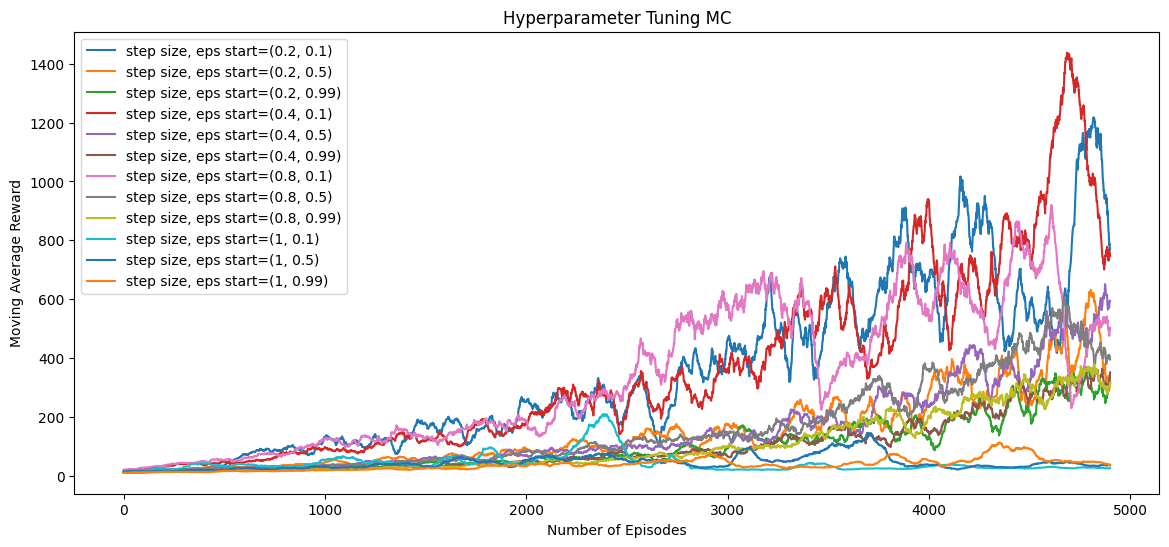

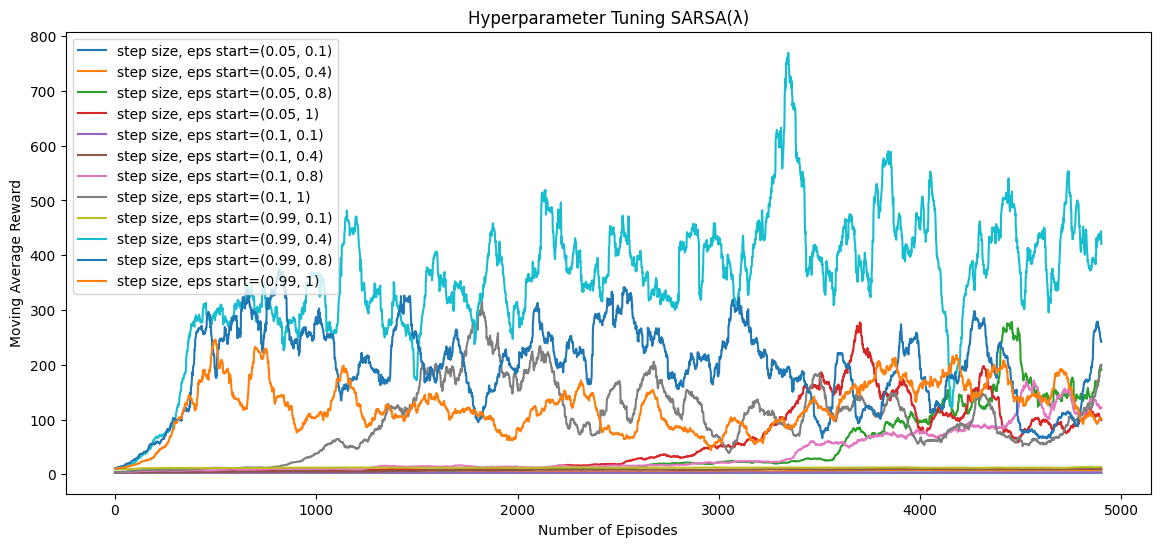

In [ ]:
# Define hyperparameter sets
mc_hyperparams = {"alpha": [0.2, 0.4, 0.8, 1], "eps_start": [0.1, 0.5, 0.99]}
sarsa_hyperparams = {"epsilon": [0.05, 0.1, 0.99], "step_size": [0.1, 0.4, 0.8, 1]}

MC_rewards = {}  # Store MC tuning results
S_rewards = {}  # Store SARSA(λ) tuning results

# MC Hyperparameter Tuning
total_trials_mc = np.prod([len(mc_hyperparams[key]) for key in mc_hyperparams.keys()])
i = 0
for alpha in mc_hyperparams['alpha']:
    for eps_start in mc_hyperparams['eps_start']:
        i += 1
        env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
        _, Q, rewards = train_mc_agent(
            env, num_episodes=5000, alpha=alpha, epsilon_start=eps_start, epsilon_decay=0.999, epsilon_min=1e-4
        )
        MC_rewards[(alpha, eps_start)] = rewards
        env.close()
        print(f"MC Trial {i}/{total_trials_mc}")

# SARSA(λ) Hyperparameter Tuning
total_trials_sarsa = np.prod([len(sarsa_hyperparams[key]) for key in sarsa_hyperparams.keys()])
i = 0
for epsilon in sarsa_hyperparams['epsilon']:
    for step_size in sarsa_hyperparams['step_size']:
        i += 1
        env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
        agent_params = {
            "num_states": 14 * 22,
            "num_actions": env.action_space.n,
            "epsilon_start": epsilon,
            "eps_decay": 0.99,
            "eps_min": 0.01,
            "step_size": step_size,
            "discount": 0.99,
            "lambd": 0.5,
            "seed": 1234
        }
        _, Q, rewards = train_sarsa_lambda(env, num_episodes=5000, agent_params=agent_params)
        S_rewards[(epsilon, step_size)] = rewards
        env.close()
        print(f"SARSA Trial {i}/{total_trials_sarsa}")

plot_hp_tuning(MC_rewards, "Number of Episodes", "Hyperparameter Tuning MC")
plot_hp_tuning(S_rewards, "Number of Episodes", "Hyperparameter Tuning SARSA(λ)")




#  **3. Try New Environments - Sensitivity Analysis of Environment Parameters**


To assess the robustness and generalization of the trained agents, we conducted a sensitivity analysis by testing performance across different environment configurations. The three key parameters analyzed were:

- **Height** of the environment `height` – Range: **7 to 25**
- **Width** of the environment `width` – Range: **7 to 25**
- **Pipe Gap** size `pipe_gap` – Range: **2 to 10**

## **Evaluation Method**
- Each agent (SARSA(λ) and MC) was tested on **10000 episodes** per configuration.
- The trained policies were frozen, meaning no further learning was allowed.
- The average cumulative reward was computed to measure agent adaptability.

## **Implementation Details**
- A function `evaluate_agent()` was implemented to run episodes and record rewards.
- For each environment setting, separate loops were executed to assess:
  - **Height Sensitivity:** Fixed width=15, pipe\_gap=4, varying height
  - **Width Sensitivity:** Fixed height=15, pipe\_gap=4, varying width
  - **Pipe Gap Sensitivity:** Fixed height=15, width=15, varying pipe gap
- After collecting the results, the mean performance for each setting was computed and plotted.

## **Findings and Insights**
- **Monte Carlo vs. SARSA(λ):**
  - **MC displayed higher stability**, maintaining consistent rewards across varying heights and widths.
  - **SARSA(λ) was more adaptive**, showing sharper increases or decreases in performance.
- **Effect of Environment Changes:**
  - Height and width changes affected SARSA(λ) more than MC.
  - Pipe gap variations impacted both agents significantly, as it alters the timing of actions.
- **Training Environment Comparison:**
  - A **dashed vertical line** marks the training environment configuration in each plot.
  - Performance drops when deviating too far from the training settings, especially for SARSA(λ).




Evaluating pipe gap sensitivity: 100%|██████████| 8/8 [00:00<00:00, 58.44it/s]


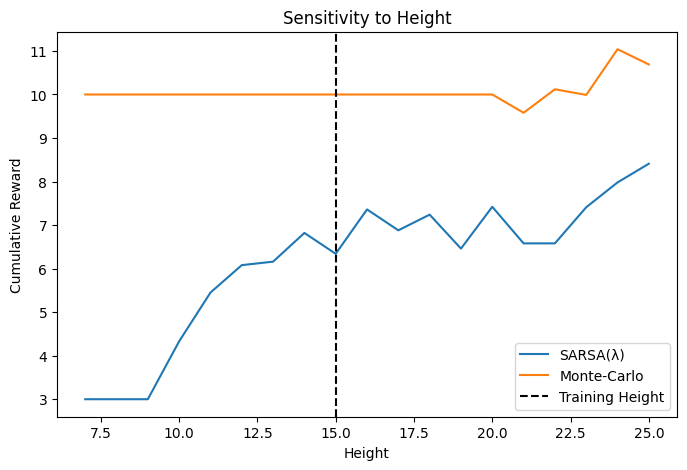

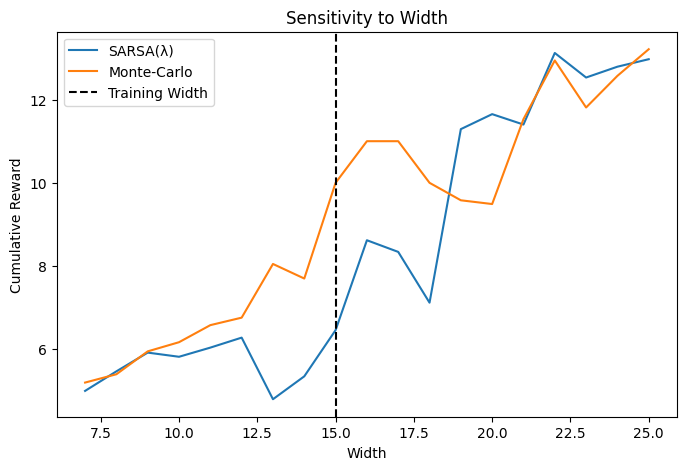

Text(0.5, 1.0, 'Sensitivity to Pipe Gap')

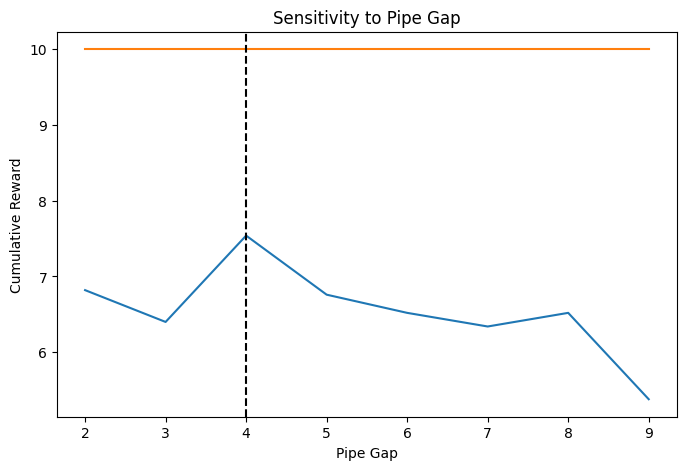

In [32]:

heights = np.arange(7, 26)
widths = np.arange(7, 26)
pipe_gaps = np.arange(2, 10)

# Store rewards for each test
h_sarsa_lambda = {h: [] for h in heights}
h_mc = {h: [] for h in heights}

w_sarsa_lambda = {w: [] for w in widths}
w_mc = {w: [] for w in widths}

p_sarsa_lambda = {p: [] for p in pipe_gaps}
p_mc = {p: [] for p in pipe_gaps}

# Number of test episodes per configuration
num_test_episodes = 10000
max_steps = 1000

# Function to evaluate agent performance
def evaluate_agent(env, policy, num_episodes=100):
    rewards = []
    for _ in range(num_episodes):
        state = env.reset()[0]
        total_reward = 0

        for _ in range(max_steps):
            action = policy[state] if state in policy else env.action_space.sample()
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward
            if done:
                break

        rewards.append(total_reward)
    return np.mean(rewards)

# Sensitivity Analysis: Height
for h in tqdm(heights, desc="Evaluating height sensitivity"):
    env_test = gym.make("TextFlappyBird-v0", height=h, width=15, pipe_gap=4)

    h_sarsa_lambda[h] = evaluate_agent(env_test, policy_sarsa)
    h_mc[h] = evaluate_agent(env_test, policy_mc)

# Sensitivity Analysis: Width
for w in tqdm(widths, desc="Evaluating width sensitivity"):
    env_test = gym.make("TextFlappyBird-v0", height=15, width=w, pipe_gap=4)

    w_sarsa_lambda[w] = evaluate_agent(env_test, policy_sarsa)
    w_mc[w] = evaluate_agent(env_test, policy_mc)

# Sensitivity Analysis: Pipe Gap
for p in tqdm(pipe_gaps, desc="Evaluating pipe gap sensitivity"):
    env_test = gym.make("TextFlappyBird-v0", height=15, width=15, pipe_gap=p)

    p_sarsa_lambda[p] = evaluate_agent(env_test, policy_sarsa)
    p_mc[p] = evaluate_agent(env_test, policy_mc)

# Convert results to mean values
h_sarsa_lambda = {k: np.mean(v) for k, v in h_sarsa_lambda.items()}
h_mc = {k: np.mean(v) for k, v in h_mc.items()}

w_sarsa_lambda = {k: np.mean(v) for k, v in w_sarsa_lambda.items()}
w_mc = {k: np.mean(v) for k, v in w_mc.items()}

p_sarsa_lambda = {k: np.mean(v) for k, v in p_sarsa_lambda.items()}
p_mc = {k: np.mean(v) for k, v in p_mc.items()}

# --- PLOTTING RESULTS ---

# Height Sensitivity
plt.figure(figsize=(8, 5))
plt.plot(h_sarsa_lambda.keys(), h_sarsa_lambda.values(), label="SARSA(λ)")
plt.plot(h_mc.keys(), h_mc.values(), label="Monte-Carlo")
plt.axvline(x=15, color="black", linestyle="--", label="Training Height")
plt.xlabel("Height")
plt.ylabel("Cumulative Reward")
plt.title("Sensitivity to Height")
plt.legend()
plt.show()

# Width Sensitivity
plt.figure(figsize=(8, 5))
plt.plot(w_sarsa_lambda.keys(), w_sarsa_lambda.values(), label="SARSA(λ)")
plt.plot(w_mc.keys(), w_mc.values(), label="Monte-Carlo")
plt.axvline(x=15, color="black", linestyle="--", label="Training Width")
plt.xlabel("Width")
plt.ylabel("Cumulative Reward")
plt.title("Sensitivity to Width")
plt.legend()
plt.show()

# Pipe Gap Sensitivity
plt.figure(figsize=(8, 5))
plt.plot(p_sarsa_lambda.keys(), p_sarsa_lambda.values(), label="SARSA(λ)")
plt.plot(p_mc.keys(), p_mc.values(), label="Monte-Carlo")
plt.axvline(x=4, color="black", linestyle="--", label="Training Pipe Gap")
plt.xlabel("Pipe Gap")
plt.ylabel("Cumulative Reward")
plt.title("Sensitivity to Pipe Gap")
